# Notebook Use Case: Log analysis with Jupyter Notebook

## Python Tuesday: Session 5

<!-- 

:date: 2019-11-22
:author: Gábor Nyers
:tags: python
:category: python workshop
:summary: Log analysis with Jupyter Notebook
:lang: en
:licence: CC BY-NC 4.0 <https://creativecommons.org/licenses/by-nc/4.0/>

-->

## Preliminary considerations:

- **Goal:** This notebook is meant to illustrate how a Jupyter notebook can be helpful for ad-hoc log analysis.
- **Out of th box Python, as much as possible:** There are numerous Python modules that can be useful for analysis (e.g.: ``pandas``), this notebook prefers to use only the Python Standard library. Notable exception is the Jupyter Notebook module(s).

## Read in file

When processing log files we need to keep a few things in mind:

- **performance**: Reading from disk is orders of magnitude slower than reading from RAM. To improve performance the data should be loaded into RAM.
- **available RAM**: Log files may can be large so loading in them RAM may not be desirable.

To make an informed choice let's check the log file's size:

In [1]:
import os
logfile = 'apache_logs-public-example'
logsize = os.path.getsize(logfile)
print('The size of "{}" is {} bytes ({:.2f}MB).'.format(os.path.basename(logfile), logsize, logsize/1024**2))

The size of "apache_logs-public-example" is 2370789 bytes (2.26MB).


If we want to limit the amount of data being loaded into RAM we may set a limit. In the next cell the ``logmaxsize`` variable can be used to limit the amount of data to be processed.

Read in the content of the log file.

In [2]:
logmaxsize = logsize
fh = open(logfile, 'r')
content = fh.readlines(logmaxsize)
fh.close()
logrecords = len(content)
print('Loaded {} lines from logfile.'.format(logrecords))

Loaded 10000 lines from logfile.


## Sample records

Let's create a few helper functions:

In [3]:
import random

def random_sample(collection, nr_of_samples=3):
    '''Return ``nr_of_samples`` random sample from ``collection``
    Return value: generator
    '''
    for i in range(nr_of_samples):
        yield random.choice(collection)

def head(collection, nr_of_elems=10):
    '''Return a generator with ``nr_of_elems`` elements form ``collection``
    '''    
    for i, elem in enumerate(collection):
        if i < nr_of_elems: yield elem
        else: break
            
def getcol(collection, idx):
    '''Assuming that ``collection`` is a table-like data structure, 
    return the ``idx``-th coloumn.
    '''
    for elem in collection:
        if idx < len(elem): yield elem[idx]

Now examine 3 random samples:

In [4]:
sep = '-' * 60
for elem in random_sample(content, 3):
    print(elem, sep)

217.12.185.5 - - [19/May/2015:14:05:34 +0000] "GET /articles/dynamic-dns-with-dhcp/ HTTP/1.1" 200 18848 "https://www.google.it/" "Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/32.0.1700.107 Safari/537.36"
 ------------------------------------------------------------
199.168.96.66 - - [18/May/2015:12:05:23 +0000] "GET /articles/efficiency/ HTTP/1.0" 200 36398 "-" "-"
 ------------------------------------------------------------
186.231.123.210 - - [19/May/2015:14:05:51 +0000] "GET /images/web/2009/banner.png HTTP/1.1" 200 52315 "http://www.semicomplete.com/blog/geekery/ec2-reserved-vs-ondemand.html" "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_0) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/32.0.1700.102 Safari/537.36"
 ------------------------------------------------------------


## Record Format Analysis

To process the log we'll need to figure out the different fields. In our example we intent to process an Apache access log, which, depening on the Apache configuration may contain different fields and possibly in custom order.

### Field separation

At first approximation the log record seem to be of CSV format, with <space> as separator and free text fields quoted. There is however a difference in the timestamp field: this is not quoted and has an extra space character.

We have at least the following options to deal with the format:

- Using the CSV module we can solve most of the problem of parsing, with some additional clean-up for the timestamp field.
- Using the Python ``re`` module (Regular Expressions) we engineer an RE, which immediately parses the log records. The benefit of this approach is that - since it is a generic solution - it will probably be more maintainable for the long run. The relative complexity that enginering a suitable RegEx may be considered a drawback.


### Parse the log

Using regular expressions is a more generic solution, so let's try that:

In [5]:
import re

apache_re = r'([\d\.]+) (.*?) (.*?) \[(.*?)\] "(.* HTTP.*)" (\d+) (\d+) "(.*)" "(.*)"'

for rec in random_sample(content, 3):
    try:
        rec_parsed = re.match(apache_re, rec).groups()
        for fieldnr, fieldval in enumerate(rec_parsed, 1):
            print('{}: {}'.format(fieldnr, fieldval))
        print('-' * 60)
    except:
        print('Could not parse log record:\n', rec)

1: 193.83.204.66
2: -
3: -
4: 19/May/2015:09:05:41 +0000
5: GET /images/web/2009/banner.png HTTP/1.1
6: 200
7: 52315
8: http://www.semicomplete.com/blog/tags/jquery%20mobile
9: Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/32.0.1700.107 Safari/537.36
------------------------------------------------------------
1: 112.110.247.227
2: -
3: -
4: 17/May/2015:18:05:08 +0000
5: GET /images/jordan-80.png HTTP/1.1
6: 200
7: 6146
8: http://www.semicomplete.com/blog/tags/X11
9: SAMSUNG-GT-E2232/1.0 Openwave/6.2.3 Profile/MIDP-2.0 Configuration/CLDC-1.1 UP.Browser/6.2.3.3.c.1.101 (GUI) MMP/2.0
------------------------------------------------------------
1: 50.16.19.13
2: -
3: -
4: 18/May/2015:03:05:11 +0000
5: GET /blog/tags/puppet?flav=rss20 HTTP/1.1
6: 200
7: 14872
8: http://www.semicomplete.com/blog/tags/puppet?flav=rss20
9: Tiny Tiny RSS/1.11 (http://tt-rss.org/)
------------------------------------------------------------


Parse the entire log content using the above method and transform the log records to a Python data structure, e.g.: list of tuples.

At this point we're fairly confident that our RegEx is correct for multiple records, but we have no certainty until we try to process the entire log content. For this reason we want to catch all records for whic the RegEx is not correct into a separate list: ``unprocessed_records``.

In [6]:
content_parsed = []             # the correctly parsed records
unprocessed_records = []        # the records not matching the RegEx
for rec_id, rec in enumerate(content):
    try:
        parsed_rec = re.match(apache_re, rec).groups()
        content_parsed.append(parsed_rec)
    except Exception:
        # Error handling: the current records did not match the RegEx, let's store it as uprocessed
        unprocessed_records.append((rec_id, rec))
print('Number of unprocessed records: {}'.format( len(unprocessed_records)))

Number of unprocessed records: 670


If the number of unprocessed records is not 0, the our RegEx in ``apache_re`` does not match each record. This means that:

1. either is our RegEx in ``apache_re`` incorrect, or
2. some of the records are of a different format.

It's prudent to assume 1. first, so let's try to examine a few records from the ``unprocecessed_records`` list:

In [7]:
for rec in head(unprocessed_records, 3):    
    print(rec)
print('RegEx:', apache_re)

(76, '218.30.103.62 - - [17/May/2015:11:05:11 +0000] "GET /robots.txt HTTP/1.1" 200 - "-" "Sogou web spider/4.0(+http://www.sogou.com/docs/help/webmasters.htm#07)"\n')
(77, '218.30.103.62 - - [17/May/2015:11:05:46 +0000] "GET /robots.txt HTTP/1.1" 200 - "-" "Sogou web spider/4.0(+http://www.sogou.com/docs/help/webmasters.htm#07)"\n')
(85, '218.30.103.62 - - [17/May/2015:11:05:17 +0000] "GET /projects/xdotool/xdotool.xhtml HTTP/1.1" 304 - "-" "Sogou web spider/4.0(+http://www.sogou.com/docs/help/webmasters.htm#07)"\n')
RegEx: ([\d\.]+) (.*?) (.*?) \[(.*?)\] "(.* HTTP.*)" (\d+) (\d+) "(.*)" "(.*)"


The problem seems to be field 7. The current RegEx assumes that this field can only be a digit, but the examples of ``unprocessed_records`` list show that this field can also be a ``-`` (dash) character. Let's modify our RegEx accordingly, i.e.: ``(\d+|-)`` instead of ``(\d+)``:

In [8]:
apache_re_modified = r'([\d\.]+) (.*?) (.*?) \[(.*?)\] "(.* HTTP.*)" (\d+) (\d+|-) "(.*)" "(.*)"'

for rec_id, rec in head(unprocessed_records, 3):               # use the unprocessed_records !    
    rec_parsed = re.match(apache_re_modified, rec).groups()    # use the modified RegEx !
    for fieldnr, fieldval in enumerate(rec_parsed, 1):
        print('{}: {}'.format(fieldnr, fieldval))
    print('-' * 60)

1: 218.30.103.62
2: -
3: -
4: 17/May/2015:11:05:11 +0000
5: GET /robots.txt HTTP/1.1
6: 200
7: -
8: -
9: Sogou web spider/4.0(+http://www.sogou.com/docs/help/webmasters.htm#07)
------------------------------------------------------------
1: 218.30.103.62
2: -
3: -
4: 17/May/2015:11:05:46 +0000
5: GET /robots.txt HTTP/1.1
6: 200
7: -
8: -
9: Sogou web spider/4.0(+http://www.sogou.com/docs/help/webmasters.htm#07)
------------------------------------------------------------
1: 218.30.103.62
2: -
3: -
4: 17/May/2015:11:05:17 +0000
5: GET /projects/xdotool/xdotool.xhtml HTTP/1.1
6: 304
7: -
8: -
9: Sogou web spider/4.0(+http://www.sogou.com/docs/help/webmasters.htm#07)
------------------------------------------------------------


In [9]:
content_parsed = []             # the correctly parsed records
unprocessed_records = []        # the records not matching the RegEx
for rec_id, rec in enumerate(content):
    try:
        parsed_rec = re.match(apache_re_modified, rec).groups()
        content_parsed.append(parsed_rec)
    except Exception:
        # Error handling: the current records did not match the RegEx, let's store it as uprocessed
        unprocessed_records.append((rec_id, rec))
print('Number of unprocessed records: {}'.format( len(unprocessed_records)))

Number of unprocessed records: 1


We have still a single unprocessed line, but this one is because of data error. **Note:** the missing ``"`` (double quote) character at the end of the line.

In [10]:
print(unprocessed_records)

[(8898, '46.118.127.106 - - [20/May/2015:12:05:17 +0000] "GET /scripts/grok-py-test/configlib.py HTTP/1.1" 200 235 "-" "Mozilla/5.0 (compatible; Googlebot/2.1; +http://www.google.com/bot.html\n')]


## Record Format and Fields

Except for fields 2 and 3 it's not difficult to guess which field is containing what information.

1. IP address
2. ?
3. ?
4. Timestamp
5. HTTP verb, URL and HTTP version
6. HTTP response code
7. Amount of bytes transmitted
8. Referring page, i.e.: the page that has referred to the URL in field 6)
9. User-Agent string

To find out the meaning of fields 2 and 3, let's try to find recrods that have something else than the ``"-"`` value. As the following cell shows, there are no log records where fields 2 and 3 have an other than ``"-"`` value.

In [11]:
records = [ elem for elem in content_parsed if elem[1] != '-' or elem[2] != '-' ]
print(records)

[]


## Clean up and convert the data

The ``content_parsed`` list contains the parsed log records, but the data is not yet in its most optimal form. Before we can start analyzing, we need to:

1. Remove redundant fields, i.e.: fields 2 and 3, which only contain meaningless ``-`` (dash) characters
2. convert the fields:
   - Timestamp: ``str -> datetime``
   - HTTP return code: ``str -> int``
   - Amount of bytes transmitted in respons: ``str -> int``

In [12]:
import datetime
convert_timestamp = lambda timestamp: datetime.datetime.strptime(timestamp, '%d/%b/%Y:%H:%M:%S %z')
def convert_nr_bytes(nr_bytes):
    try:
        return int(nr_bytes)
    except Exception:
        return 0

def convert_rec(rec):
    ipaddr, throwaway1, throwaway2, timestamp, req_url, resp_code, nr_bytes, ref_url, agent_str = rec
    return (ipaddr, convert_timestamp(timestamp), req_url, int(resp_code),
            convert_nr_bytes(nr_bytes), ref_url, agent_str)

Sample of the cleaned up data:

In [13]:
content_cleaned = tuple(map(convert_rec, content_parsed))
for rec in random_sample(content_cleaned):
    print(rec, sep)

('203.99.205.107', datetime.datetime(2015, 5, 19, 3, 5, 47, tzinfo=datetime.timezone.utc), 'GET /presentations/logstash-monitorama-2013/css/fonts/xjAJXh38I15wypJXxuGMBp0EAVxt0G0biEntp43Qt6E.ttf HTTP/1.1', 200, 34416, 'http://semicomplete.com/presentations/logstash-monitorama-2013/css/fonts/OpenSans.css', 'Mozilla/5.0 (Windows NT 6.1; rv:25.0) Gecko/20100101 Firefox/25.0') ------------------------------------------------------------
('76.2.185.161', datetime.datetime(2015, 5, 18, 13, 5, 32, tzinfo=datetime.timezone.utc), 'GET /favicon.ico HTTP/1.1', 200, 3638, '-', 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Ubuntu Chromium/32.0.1700.102 Chrome/32.0.1700.102 Safari/537.36') ------------------------------------------------------------
('184.66.149.103', datetime.datetime(2015, 5, 20, 20, 5, 46, tzinfo=datetime.timezone.utc), 'GET /presentations/logstash-monitorama-2013/plugin/zoom-js/zoom.js HTTP/1.1', 200, 7697, 'http://semicomplete.com/presentations/logstash

## Log Analysis

### Aggregation

To quickly oversee important information in a large amount of data we use aggregation. In Python we can use the built-in `dict` data type for aggregation.

#### What are the 10 most frequent IP addresses?

What are the most frequent IP addresses in the log? How many times do they occur?

In [14]:
import collections

ip_cntr = collections.Counter(getcol(content_cleaned, 0))
print(ip_cntr.most_common(10))

[('66.249.73.135', 482), ('46.105.14.53', 364), ('130.237.218.86', 357), ('75.97.9.59', 273), ('50.16.19.13', 113), ('209.85.238.199', 102), ('68.180.224.225', 99), ('100.43.83.137', 84), ('208.115.111.72', 83), ('198.46.149.143', 82)]


#### How many distinct IP address are there?


In [15]:
print('The number of distinct IP addresses:', len(ip_cntr))

The number of distinct IP addresses: 1753


#### What is the timespan of the logs?

Find the earliest and latest date in the data. 

**Essentially**: find the min. and max. value in a collection of data.

In [16]:
def minmax(collection):
    '''Return the smallest and largest elements of the collection    
    '''
    mi, ma = None, None
    for rec in collection:
        if not(mi): mi = rec     # in 1st round mi = current record
        if not(ma): ma = rec     # in 1st round ma = current record
        if rec < mi: mi = rec    # update ``mi`` if current record is smaller/less/earlier
        if rec > ma: ma = rec    # update ``ma`` if current record is larger/more/later
    return mi, ma
        
earliest, latest = minmax(getcol(content_cleaned, 1))
#latest = max(getcol(content_cleaned, 1))
print('Timespan: {} - {} ({})'.format(earliest, latest, latest-earliest))

Timespan: 2015-05-17 10:05:00+00:00 - 2015-05-20 21:05:59+00:00 (3 days, 11:00:59)


In [17]:
# sample data: the ages of a group of people
ages = [ 32, 13, 26, 9, 23, 46, 72, 67, 29, 78, 45, 51, 49]

# question: how many people if the age groups of 0-9, 10-19, 20-29, 30-39 etc...

# as demonstration, the above list sorted:
#     [ 9,   13, 23, 26, 29,   32, 45, 46, 49,    51,   67, 72, 78 ]
#        |     |           |     |           |      |      |      |
#     0-9 10-19    20-29    30-39    40-49     50-59  60-69  70-79 

age_histogram = {}                                 # empty dict for the grouping
for age in ages:
    age_grp = age // 10 * 10                       # integer division, i.e.: (34 // 10) * 10 = 30
    age_histogram[age_grp] = age_histogram.get(age_grp, 0) + 1

# print age_histogram:
for age_grp in sorted(age_histogram):
    print('{}: {}'.format(age_grp, age_histogram[age_grp]))

0: 1
10: 1
20: 3
30: 1
40: 3
50: 1
60: 1
70: 2


Now apply the above aggregation algorithm for our data, and find out how many requests were per day.

In [18]:
# Count nr. of requests per day
nr_of_req_by_date = {}                             # empty dict, used for count recors
for ip, date, *rest in content_cleaned:            # loop through the cleaned logs
    date_day = date.strftime('%Y-%m-%d')           # take the day part of timestamp
    nr_of_req_by_date[date_day] = nr_of_req_by_date.get(date_day, 0) + 1

### Illustrations with graphs

See also: [PyPlot Tutorial](https://matplotlib.org/stable/tutorials/introductory/pyplot.html)

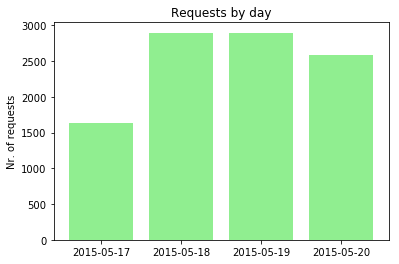

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt

# Separate data into 2 sequences; needed for the plt.plot() function
days = list(getcol(nr_of_req_by_date.items(), 0))  # get the 1st col and convert to list
nrs = list(getcol(nr_of_req_by_date.items(), 1))   # samen as above but for the 2nd col.
    
# Plot data:
plt.ylabel('Nr. of requests')
plt.title('Requests by day')
fig1 = plt.bar(days, nrs, linestyle='--', linewidth=2.5, color='lightgreen')

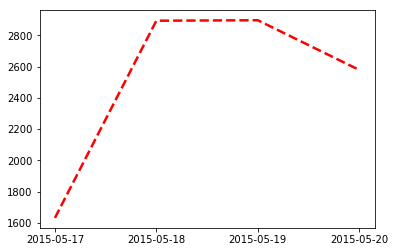

In [20]:
fig2 = plt.plot(days, nrs, linestyle='--', linewidth=2.5, color='red', zorder=-1)

## Bonus: User-Agent statistics

**Questions**:

- How many different User-Agents?
- What are the 10 most frequently occuring User-Agents?

**Note**:

- because the User-Agent strings can be very long (>150 chars), we'll use the `textwrap` module to nicely wrap the output

In [21]:
# prepare the text-wrapper
import textwrap as tw
w = tw.TextWrapper(width=70, initial_indent='  - ', subsequent_indent='    ')

# The data
agents = collections.Counter(getcol(content_cleaned,6))
print('- There are **{}** distinct agent strings in the logs.'.format(len(agents)))
print('- The top 10 most frequent agents are:')
for agent_str, seen in agents.most_common(10):
    line = '{}: {}'.format(seen, agent_str)
    line_wrapped = '\n'.join(w.wrap(line))
    print(line_wrapped)

- There are **558** distinct agent strings in the logs.
- The top 10 most frequent agents are:
  - 1044: Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36
    (KHTML, like Gecko) Chrome/32.0.1700.107 Safari/537.36
  - 369: Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_1)
    AppleWebKit/537.36 (KHTML, like Gecko) Chrome/33.0.1750.91
    Safari/537.36
  - 364: UniversalFeedParser/4.2-pre-314-svn +http://feedparser.org/
  - 296: Mozilla/5.0 (Windows NT 6.1; WOW64; rv:27.0) Gecko/20100101
    Firefox/27.0
  - 271: Mozilla/5.0 (iPhone; CPU iPhone OS 6_0 like Mac OS X)
    AppleWebKit/536.26 (KHTML, like Gecko) Version/6.0 Mobile/10A5376e
    Safari/8536.25 (compatible; Googlebot/2.1;
    +http://www.google.com/bot.html)
  - 268: Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML,
    like Gecko) Chrome/32.0.1700.107 Safari/537.36
  - 237: Mozilla/5.0 (compatible; Googlebot/2.1;
    +http://www.google.com/bot.html)
  - 236: Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:27.0)
    Geck

### Google Search engine statistics

The search engines are recognizable from their User-Agent string.

#### Find out which Google related User-Agent strings are there

It would seem that the 'Googlebot' string is what identifies the Google Search Engine. (for more visit http://www.google.com/bot.html)

In [22]:
# declare a simple, one-time used filter function with the "lambda" notation
filter_f = lambda s: 'google' in s.lower()  # return False if agent name does not contain 'google'

for a in filter(filter_f, agents):
    print(a)

Mozilla/5.0 (iPhone; CPU iPhone OS 6_0 like Mac OS X) AppleWebKit/536.26 (KHTML, like Gecko) Version/6.0 Mobile/10A5376e Safari/8536.25 (compatible; Googlebot/2.1; +http://www.google.com/bot.html)
Mozilla/5.0 (compatible; Googlebot/2.1; +http://www.google.com/bot.html)
Feedfetcher-Google; (+http://www.google.com/feedfetcher.html; 3 subscribers; feed-id=14171215010336145331)
Feedfetcher-Google; (+http://www.google.com/feedfetcher.html; 1 subscribers; feed-id=11390274670024826467)
DoCoMo/2.0 N905i(c100;TB;W24H16) (compatible; Googlebot-Mobile/2.1; +http://www.google.com/bot.html)
Feedly/1.0 (+http://www.feedly.com/fetcher.html; like FeedFetcher-Google)
Feedfetcher-Google; (+http://www.google.com/feedfetcher.html; 16 subscribers; feed-id=3389821348893992437)
Feedfetcher-Google; (+http://www.google.com/feedfetcher.html; 22 subscribers; feed-id=8321906634162087507)
Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/32.0.1700.107 Safari/537.36,gzip(g

#### Records with the string "Googlebot"

In [23]:
rec_googlebot = tuple( filter(lambda s: 'googlebot' in s.lower(), agents))
print('There are {} visits in the logs.'.format(len(rec_googlebot)))
for rec in rec_googlebot:
    print(' -', rec)

There are 6 visits in the logs.
 - Mozilla/5.0 (iPhone; CPU iPhone OS 6_0 like Mac OS X) AppleWebKit/536.26 (KHTML, like Gecko) Version/6.0 Mobile/10A5376e Safari/8536.25 (compatible; Googlebot/2.1; +http://www.google.com/bot.html)
 - Mozilla/5.0 (compatible; Googlebot/2.1; +http://www.google.com/bot.html)
 - DoCoMo/2.0 N905i(c100;TB;W24H16) (compatible; Googlebot-Mobile/2.1; +http://www.google.com/bot.html)
 - SAMSUNG-SGH-E250/1.0 Profile/MIDP-2.0 Configuration/CLDC-1.1 UP.Browser/6.2.3.3.c.1.101 (GUI) MMP/2.0 (compatible; Googlebot-Mobile/2.1; +http://www.google.com/bot.html)
 - Googlebot-Image/1.0
 - Mozilla/5.0 (compatible; Googlebot/2.1;+http://www.google.com/bot.html)


#### Google Desktop crawler

According to https://support.google.com/webmasters/answer/1061943?hl=en, the User-Agent string of the Google crawler is similar to this RegEx: ``r'^Mozilla.5.0 .+compatible; Googlebot.2.1; ?.http'``. To find out the date of the latest visit:


In [24]:
google_crawler_re = r'^Mozilla.5.0 .+compatible; Googlebot.2.1; ?.http'
filter_func = lambda rec: re.match(google_crawler_re, rec[6]) and (not 'iphone' in rec[6].lower())

google_crawler_records = tuple(filter(filter_func, content_cleaned))
google_crawler_visits_nr = len(google_crawler_records)
print('There have been {} visits formt he Google crawler.'.format(google_crawler_visits_nr))
first_visit, last_visit = minmax(getcol(google_crawler_records, 1))
d = (last_visit - first_visit) / len(google_crawler_records)
print('The average interval between visits have been {:.1f} seconds / {:.1f} minutes.'.format(d.seconds, d.seconds/60))

There have been 238 visits formt he Google crawler.
The average interval between visits have been 1255.0 seconds / 20.9 minutes.
